**Import modules and .txt files as dataframe, then plot to see data**

In [375]:
# Import modules
from datetime import datetime
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MultipleLocator

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [376]:
## Import nmdb data (OULU, THUL, SOPO)
colnames = ['datetime', 'OULU', 'THUL', 'SOPO']
filenames = ['data_2min_fd2015.txt', 'data_2min_fd2021.txt',
             'data_2min_2005_1.txt', 'data_2min_2005_2.txt', 'data_2min_2005_3.txt',
             'data_2min_2022_1.txt', 'data_2min_2022_2.txt', 'data_2min_2022_3.txt',
             'data_2min_2023_1.txt', 'data_2min_2023_2.txt', 'data_2min_2023_3.txt',
             'data_2min_2024_1.txt', 'data_2min_2024_2.txt', 'data_2min_2024_3.txt']
dataframes = []

def read_and_clean_txt(filename, colnames):
    stations = colnames[1:]
    df = pd.read_csv(filename, sep=';', comment='#', names=colnames) # Import
    df = df.drop(index=0).reset_index(drop=True) # Remove first row
    df.datetime = pd.to_datetime(df.datetime, format="%Y-%m-%d %H:%M:%S") # Convert to datetime
    for s in stations: # Convert invalid data to nan
        df[s] = pd.to_numeric(df[s], errors='coerce')
        df[s] = df[s].bfill()   # backward fill
    return df
        
for filename in filenames:
    df = read_and_clean_txt(filename, colnames)
    dataframes.append(df) # Add to df list

# Extract as individual dataframes
fd15, fd21, data05_1, data05_2, data05_3, data22_1, data22_2, data22_3, data23_1, data23_2, data23_3, data24_1, data24_2, data24_3 = dataframes

# Merge data05, data22, data23, data24
data05 = pd.concat([data05_1, data05_2, data05_3], ignore_index=True)
data22 = pd.concat([data22_1, data22_2, data22_3], ignore_index=True)
data23 = pd.concat([data23_1, data23_2, data23_3], ignore_index=True)
data24 = pd.concat([data24_1, data24_2, data24_3], ignore_index=True)


## Import nmdb data (AATB, lMKS) -- Downloaded later on
# Concatenate FD data to first 2 dataframes
def merge_with_filename(df_to_merge, filename, colnames):
    another_df = read_and_clean_txt(filename, colnames)
    df_merged = df_to_merge.merge(another_df, on='datetime', how='outer')
    return df_merged

colnames = ['datetime', 'AATB', 'LMKS']
fd15 = merge_with_filename(fd15, 'data_2min_fd2015_LMKS+AATB.txt', colnames)
fd21 = merge_with_filename(fd21, 'data_2min_fd2021_LMKS+AATB.txt', colnames)

# Concatenate FD data to the rest of the dataframes
for s in ['AATB', 'LMKS']:
    colnames = ['datetime', s]
    data05 = merge_with_filename(data05, f'data_2min_2005_{s}.txt', colnames)
    data22 = merge_with_filename(data22, f'data_2min_2022_{s}.txt', colnames)
    data23 = merge_with_filename(data23, f'data_2min_2023_{s}.txt', colnames)
    data24 = merge_with_filename(data24, f'data_2min_2024_{s}.txt', colnames)

# Reset dataframes
dataframes = [fd15, fd21, data05, data22, data23, data24]

# Show dataframe
stations = ['OULU', 'THUL', 'SOPO', 'AATB', 'LMKS']  # Final station list
data05

,datetime,OULU,THUL,SOPO,AATB,LMKS
0,2005-01-01 00:00:00,102.878,115.610,287.055,1368.85,422.034
1,2005-01-01 00:02:00,101.313,114.330,286.695,1395.75,422.425
2,2005-01-01 00:04:00,103.435,116.180,284.750,1374.85,430.050
3,2005-01-01 00:06:00,100.498,115.440,284.735,1377.65,438.716
4,2005-01-01 00:08:00,100.452,116.925,286.435,1383.70,425.375
...,...,...,...,...,...,...
250555,2005-12-14 23:50:00,105.435,121.250,NaN,1443.90,449.992
250556,2005-12-14 23:52:00,104.610,122.380,NaN,1436.60,446.092
250557,2005-12-14 23:54:00,106.469,120.665,NaN,1433.85,446.350
250558,2005-12-14 23:56:00,106.546,122.065,NaN,1449.35,444.250


In [377]:
# Draw baseline for each offset station data
def draw_baselines(ax, offset, interval):
    lw = 0.5
    for n in range(-2, 3):
        ax.axhline(y=offset + n * interval, linestyle="--", linewidth=lw, color='black')

# Set change x-axis to day of year and limit to 0-350
def set_xaxis_DoY(ax, times):
    ax.xaxis.set_major_formatter( # Set x-axis to DoY
        FuncFormatter(lambda x, _: mdates.num2date(x).timetuple().tm_yday)
    )
    
    # Limit x-axis DoY to 0-350
    year0 = times.dt.year.min()
    xmin = pd.Timestamp(year0, 1, 1) + pd.Timedelta(days=0)
    xmax = pd.Timestamp(year0, 1, 1) + pd.Timedelta(days=350)
    ax.set_xlim(xmin, xmax)

    # Set ticker interval to be 25 days counting from 0
    ticks = [xmin + pd.Timedelta(days=d) for d in range(0, 351, 20)]
    ax.set_xticks(ticks)

def set_xaxis_DoY_4times(ax):
    ax0, ax1, ax2, ax3 = ax
    set_xaxis_DoY(ax0, data05.datetime)
    set_xaxis_DoY(ax1, data22.datetime)
    set_xaxis_DoY(ax2, data23.datetime)
    set_xaxis_DoY(ax3, data24.datetime)

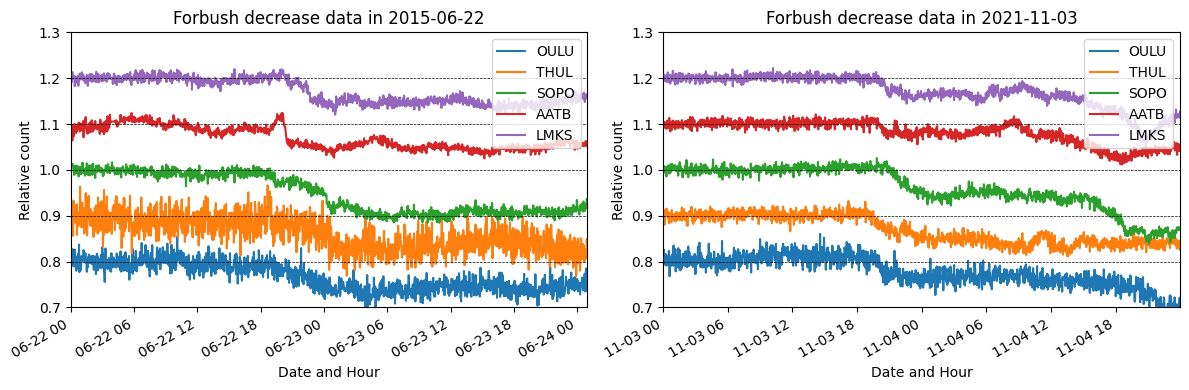

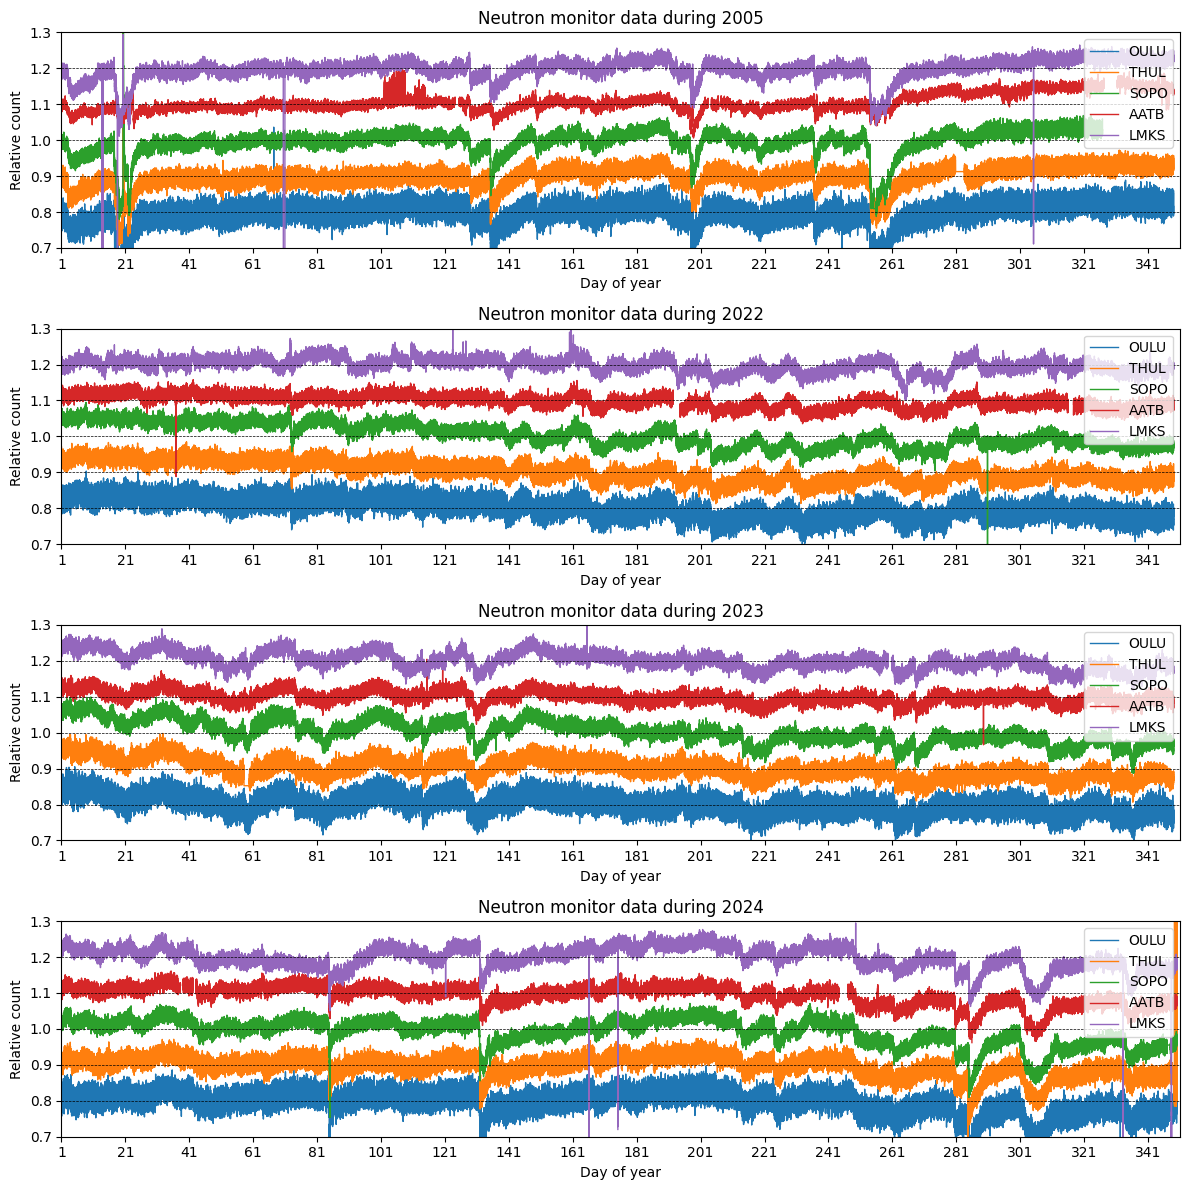

In [397]:
# Plot Forbush decrease data
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax1, ax2 = ax

for i, s in enumerate(stations):
    shift = (i-2) * 0.1
    ax1.plot(fd15.datetime, fd15[s] / fd15[s][:30*6].median() + shift, label=s)
    ax2.plot(fd21.datetime, fd21[s] / fd21[s][:30*6].median() + shift, label=s)

ax1.set_title('Forbush decrease data in 2015-06-22')
ax1.set_xlim(fd15.datetime.min(), fd15.datetime.max())
ax2.set_title('Forbush decrease data in 2021-11-03')
ax2.set_xlim(fd21.datetime.min(), fd21.datetime.max())

for a in ax:
    a.set_ylabel('Relative count')
    a.set_xlabel('Date and Hour')
    a.legend(loc='upper right')
    a.set_ylim(0.7, 1.3)
    draw_baselines(a, 1, 0.1)
    
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Plot year-long neutron monitor data
fig, ax = plt.subplots(4, 1, figsize=(12, 12))
ax0, ax1, ax2, ax3 = ax

for i, s in enumerate(stations):
    shift = (i-2) * 0.1
    ax0.plot(data05.datetime, data05[s] / data05[s].median() + shift, label=s, linewidth=1)
    ax1.plot(data22.datetime, data22[s] / data22[s].median() + shift, label=s, linewidth=1)
    ax2.plot(data23.datetime, data23[s] / data23[s].median() + shift, label=s, linewidth=1)
    ax3.plot(data24.datetime, data24[s] / data24[s].median() + shift, label=s, linewidth=1)

set_xaxis_DoY_4times(ax)
ax0.set_title('Neutron monitor data during 2005')
ax1.set_title('Neutron monitor data during 2022')
ax2.set_title('Neutron monitor data during 2023')
ax3.set_title('Neutron monitor data during 2024')

for a in ax:
    a.set_ylabel('Relative count')
    a.set_xlabel('Day of year')
    a.legend(loc='upper right')
    a.set_ylim(0.7, 1.3)
    draw_baselines(a, 1, 0.1)

plt.tight_layout()
plt.show()

**Signal processing before applying CCF!**

Long-term signal movement removal with from-running-mean (12 h) calculations

In [379]:
def from_rolling_mean(signal): # from 12-hour rolling mean of smoothed signal
    minutes = 60 * 12
    window = int(minutes/2)

    rolling_mean = signal.rolling(window=window, min_periods=1).mean()  
    signal_frm = signal - rolling_mean
    return signal_frm

In [380]:
# Get from-rolling-mean data
for df in dataframes:
    for s in stations:
        df[f'{s}_frm'] = from_rolling_mean(df[s])

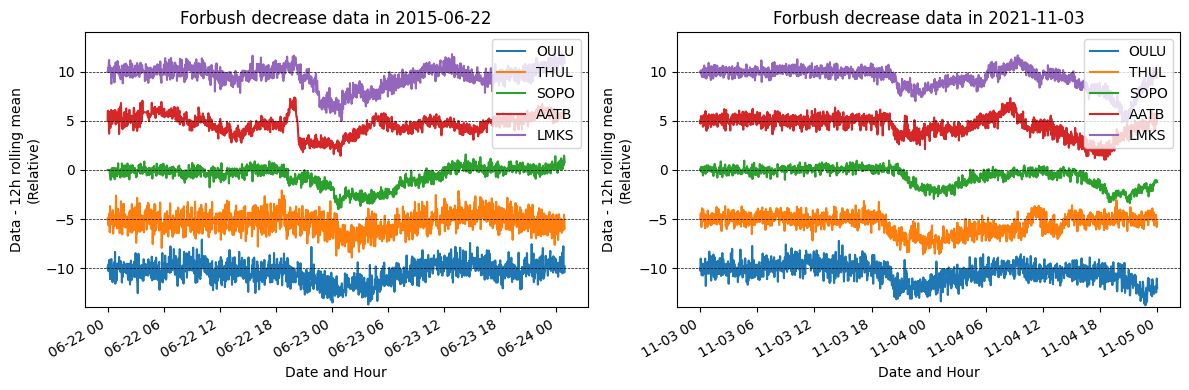

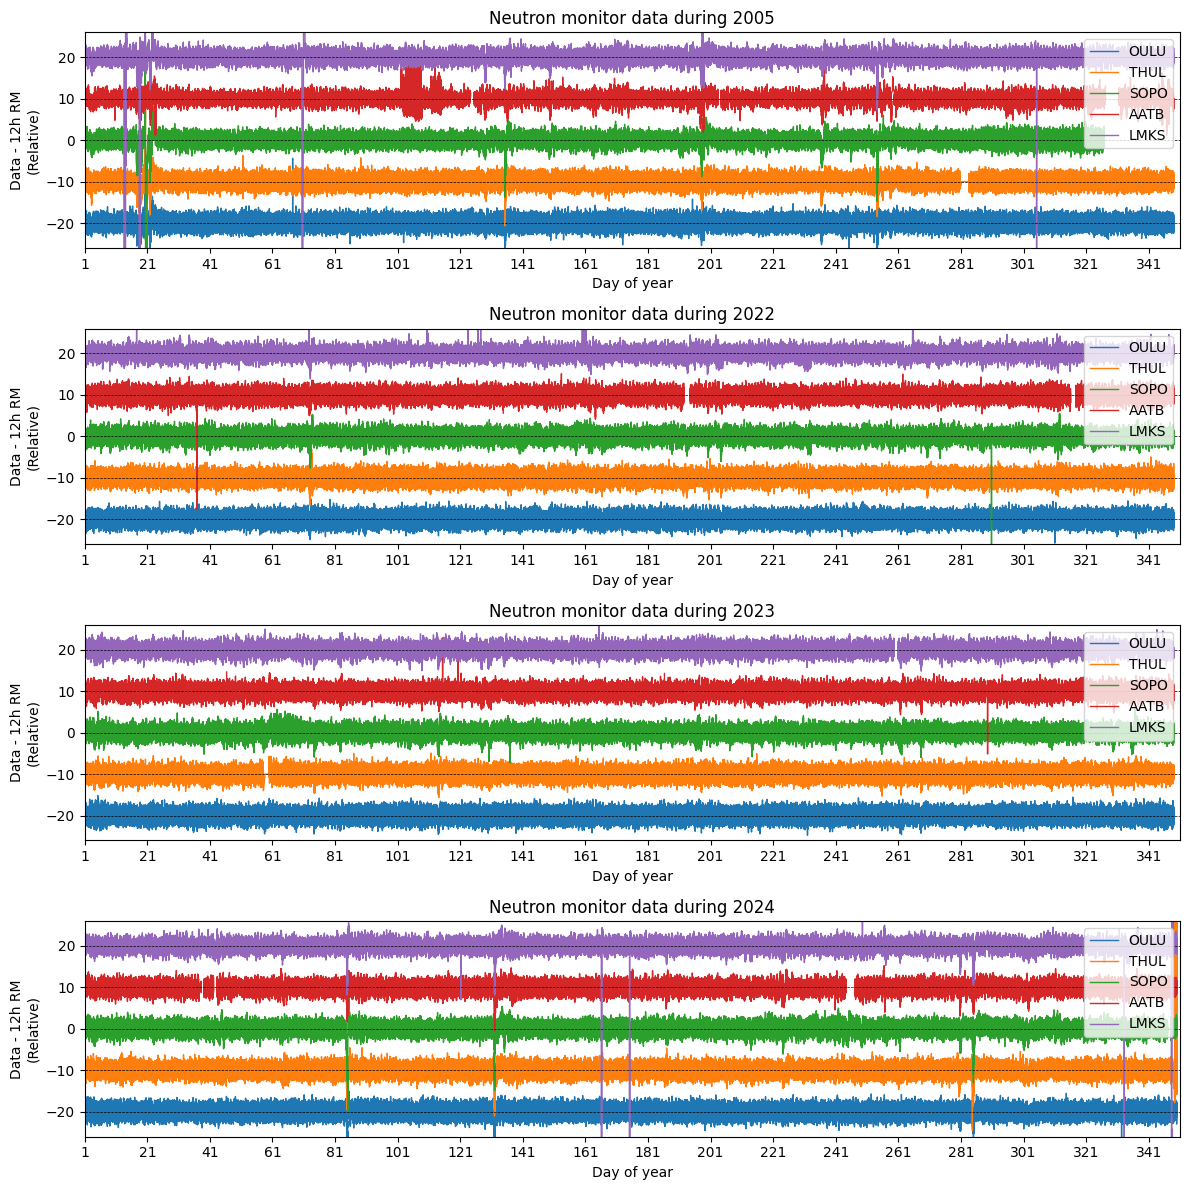

In [381]:
# Plot Forbush decrease data (from 12h rolling mean)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax1, ax2 = ax

def onesigma(df):
    one_sigma = 0.5 * (np.nanpercentile(df, 84) - np.nanpercentile(df, 16))
    return one_sigma

for i, s in enumerate(stations):
    shift = (i-2) * 5
    colname = f'{s}_frm'
    ax1.plot(fd15.datetime, fd15[colname] / onesigma(fd15[colname]) + shift, label=s)
    ax2.plot(fd21.datetime, fd21[colname] / onesigma(fd21[colname]) + shift, label=s)

ax1.set_title('Forbush decrease data in 2015-06-22')
ax2.set_title('Forbush decrease data in 2021-11-03')

for a in ax:
    a.set_ylabel('Data - 12h rolling mean\n(Relative)')
    a.set_xlabel('Date and Hour')
    a.legend(loc='upper right')
    draw_baselines(a, 0, 5)
    a.set_ylim(-14, 14)
    
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Plot year-long neutron monitor data (from running mean)
fig, ax = plt.subplots(4, 1, figsize=(12, 12))
ax0, ax1, ax2, ax3 = ax

for i, s in enumerate(stations):
    shift = (i-2) * 10
    colname = f'{s}_frm'
    ax0.plot(data05.datetime, data05[colname] / onesigma(data05[colname]) + shift, label=s, linewidth=1)
    ax1.plot(data22.datetime, data22[colname] / onesigma(data22[colname]) + shift, label=s, linewidth=1)
    ax2.plot(data23.datetime, data23[colname] / onesigma(data23[colname]) + shift, label=s, linewidth=1)
    ax3.plot(data24.datetime, data24[colname] / onesigma(data24[colname]) + shift, label=s, linewidth=1)

set_xaxis_DoY_4times(ax)
ax0.set_title('Neutron monitor data during 2005')
ax1.set_title('Neutron monitor data during 2022')
ax2.set_title('Neutron monitor data during 2023')
ax3.set_title('Neutron monitor data during 2024')

for a in ax:
    a.set_ylabel('Data - 12h RM\n(Relative)')
    a.set_xlabel('Day of year')
    a.legend(loc='upper right')
    draw_baselines(a, 0, 10)
    a.set_ylim(-26, 26)

plt.tight_layout()
plt.show()

**Discrete-time cross correlation of NM signal and historical FD signal**

In [382]:
# Cross-correlation
def CCF(signal, fd):
    # Makes nan to zero to avoid null results
    signal_clean = np.nan_to_num(signal, nan=0.0)
    fd_clean = np.nan_to_num(fd, nan=0.0)

    # Compute CCF
    # For visualization and CCF thresholding, return relative CCF which is essentially z-score of CCF
    CCF = scipy.signal.correlate(signal_clean, fd_clean, mode='full')
    CCF_med, CCF_std = np.nanmedian(CCF), 0.5 * (np.nanpercentile(CCF, 84) - np.nanpercentile(CCF, 16))
    relative_CCF = (CCF - CCF_med) / CCF_std
    
    lags = np.arange(-len(fd)+1, len(signal))
    # Lags to day of year (2-min interval) + 1 day offset (DoY starts at 1)
    DoY = lags / (30 * 24) + 1
    return DoY, relative_CCF

**Compute cross-correlation and plot**

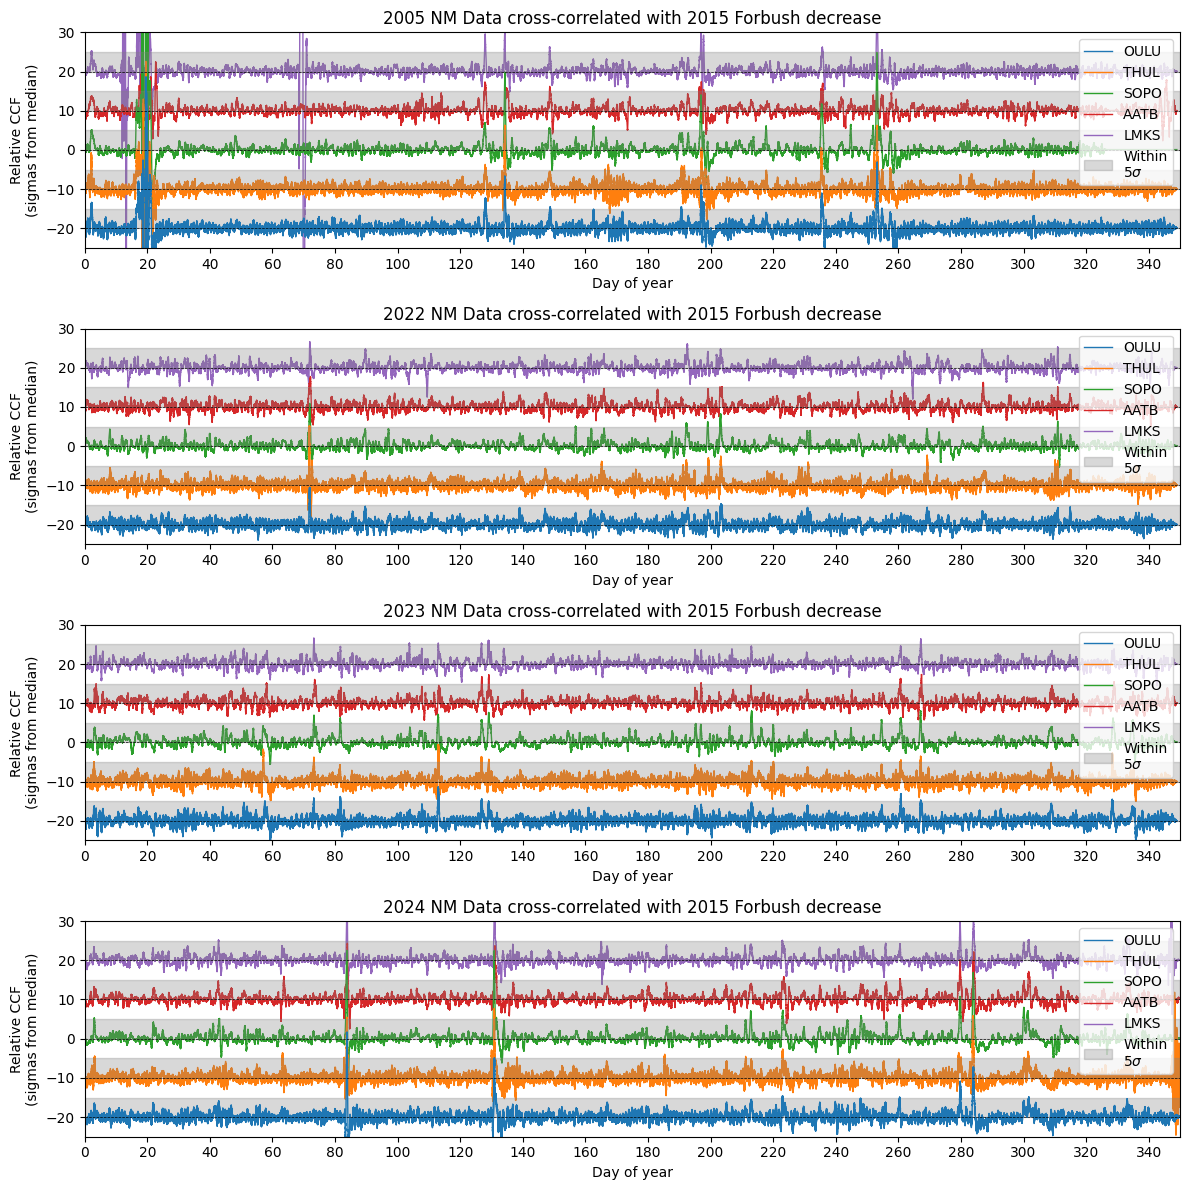

In [383]:
# Plot year-long CCF
fig, ax = plt.subplots(4, 1, figsize=(12, 12))
ax0, ax1, ax2, ax3 = ax
fd = fd15  # FD to choose (2015)

for i, s in enumerate(stations):
    shift = (i-2) * 10
    station_colname = f'{s}_frm'
    doy05, ccf05 = CCF(data05[station_colname], fd[station_colname])
    doy22, ccf22 = CCF(data22[station_colname], fd[station_colname])
    doy23, ccf23 = CCF(data23[station_colname], fd[station_colname])
    doy24, ccf24 = CCF(data24[station_colname], fd[station_colname])

    ax0.plot(doy05, ccf05 + shift, label=s, linewidth=1, zorder=-shift/10)
    ax1.plot(doy22, ccf22 + shift, label=s, linewidth=1, zorder=-shift/10)
    ax2.plot(doy23, ccf23 + shift, label=s, linewidth=1, zorder=-shift/10)
    ax3.plot(doy24, ccf24 + shift, label=s, linewidth=1, zorder=-shift/10)

ax0.set_title('2005 NM Data cross-correlated with 2015 Forbush decrease')
ax1.set_title('2022 NM Data cross-correlated with 2015 Forbush decrease')
ax2.set_title('2023 NM Data cross-correlated with 2015 Forbush decrease')
ax3.set_title('2024 NM Data cross-correlated with 2015 Forbush decrease')

for a in ax:
    a.set_ylabel('Relative CCF\n(sigmas from median)')
    a.set_xlabel('Day of year')
    a.set_xlim(0, 350)
    a.set_ylim(-25, 30)
    a.xaxis.set_major_locator(MultipleLocator(20))
    draw_baselines(a, 0, 10)

    alpha=0.3
    a.axhspan(20, 25, color='grey', alpha=alpha)
    a.axhspan(10, 15, color='grey', alpha=alpha)
    a.axhspan(0, 5, color='grey', alpha=alpha, label='Within\n$5\sigma$') 
    a.axhspan(-10, -5, color='grey', alpha=alpha) 
    a.axhspan(-20, -15, color='grey', alpha=alpha) 

    a.legend(loc='upper right')

plt.tight_layout()
plt.show()

**Record all times with relative CCF > 5 sigma in 5 stations simultaneously**

In [384]:
# Create dataframe for year, DoY, and relative CCFs
ccf_df_list = [] # List of dataframes with dfs for further analysis
for s in stations:
    station_colname = f'{s}_frm'
    doy05, ccf05 = CCF(data05[station_colname], fd[station_colname])
    doy22, ccf22 = CCF(data22[station_colname], fd[station_colname])
    doy23, ccf23 = CCF(data23[station_colname], fd[station_colname])
    doy24, ccf24 = CCF(data24[station_colname], fd[station_colname])
    
    # FD actually occurs 20 hours in the FD signal used in CCF.
    # So we must account for this when considering the date
    doy_offset = 20/24
    
    ccf_df = pd.DataFrame({
        'year': np.repeat([2005, 2022, 2023, 2024], # Year array
                          [len(doy05), len(doy22), len(doy23), len(doy24)]),
    
        'doy': np.concatenate([doy05, doy22, doy23, doy24]) + doy_offset,
        f'ccf_{s}': np.concatenate([ccf05, ccf22, ccf23, ccf24]),
    })
    ccf_df_list.append(ccf_df)

# Merge all dfs in ccf_df_list
merged_df = ccf_df_list[0]
for d in ccf_df_list[1:]:
    merged_df = merged_df.merge(d, on=merged_df.columns[:2].tolist())

merged_df

,year,doy,ccf_OULU,ccf_THUL,ccf_SOPO,ccf_AATB,ccf_LMKS
0,2005,-0.206944,0.100990,0.103545,0.091051,0.049810,0.068225
1,2005,-0.205556,0.100161,0.108191,0.090822,0.056763,0.068395
2,2005,-0.204167,0.103889,0.099506,0.088886,0.050500,0.073018
3,2005,-0.202778,0.097580,0.098704,0.086444,0.049469,0.084502
4,2005,-0.201389,0.104736,0.102471,0.086076,0.055877,0.087834
...,...,...,...,...,...,...,...
1008831,2024,350.826389,0.093084,0.150638,0.181536,0.086481,0.063660
1008832,2024,350.827778,0.098497,0.139549,0.181536,0.089898,0.059559
1008833,2024,350.829167,0.090727,0.145643,0.181536,0.085310,0.061311
1008834,2024,350.830556,0.092740,0.124116,0.181536,0.095540,0.060317


In [391]:
# Then, filter merged df with with 5-sigma clipping
sigmas = 5
min_leeway = 60 * 10  # plus-minus 10-hour leeway for peaks over 5 sigma (Accounts for delays)
ccf_cols = ["ccf_OULU", "ccf_THUL", "ccf_SOPO", "ccf_AATB", "ccf_LMKS"]

raw_masks = [(merged_df[col] > sigmas) for col in ccf_cols]
leeway_masks = [msk.rolling(int(min_leeway/2), center=True, min_periods=1) \
                .max().astype(bool) for msk in raw_masks]  # Expand to leeway
station_combined_mask = np.logical_and.reduce(leeway_masks)

# Finally, remove consecutive TRUEs in station_combined_mask, leaving the middle one.
def collapse_True_islands(mask):
    # Find island boundaries
    starts = np.where(mask & ~np.r_[False, mask[:-1]])[0]
    ends   = np.where(mask & ~np.r_[mask[1:], False])[0]
    
    # Build output mask
    out = np.zeros_like(mask, dtype=bool)
    for s, e in zip(starts, ends):
        mid = (s + e) // 2
        out[mid] = True
    
    return out

final_mask = collapse_True_islands(station_combined_mask)
filtered_df = merged_df[final_mask]

# Insert floor of DoY to get day of year
filtered_df.insert(2, "doy_floor", np.int32(np.floor(filtered_df.doy)))
filtered_df

,year,doy,doy_floor,ccf_OULU,ccf_THUL,ccf_SOPO,ccf_AATB,ccf_LMKS
13515,2005,18.563889,18,6.194553,4.107453,10.355933,3.962531,-2.983273
15869,2005,21.833333,21,12.154036,4.419753,15.316543,5.454945,8.138693
92895,2005,128.813889,128,6.792632,4.635525,6.640454,6.774706,9.242105
97630,2005,135.390278,135,3.867952,1.895681,6.213325,3.329647,0.612089
142364,2005,197.520833,197,0.200704,-1.694517,8.400789,1.531111,3.222546
142626,2005,197.884722,197,9.292110,9.593132,11.617316,7.172275,8.950258
170385,2005,236.438889,236,7.984335,5.722133,11.004668,2.669298,5.495681
183030,2005,254.001389,254,15.521870,15.232395,24.613838,7.491745,18.243917
304566,2022,72.761111,72,8.109574,11.928415,10.649795,6.242646,6.478392
557617,2023,74.180556,74,3.275636,4.261310,5.852880,3.558309,4.770288


In [392]:
# Finally, get only the UNIQUE year and doy_floor
filtered_df_doy_only = filtered_df[["year", "doy_floor"]] \
                       .drop_duplicates() \
                       .reset_index(drop=True)
filtered_df_doy_only

,year,doy_floor
0,2005,18
1,2005,21
2,2005,128
3,2005,135
4,2005,197
5,2005,236
6,2005,254
7,2022,72
8,2023,74
9,2023,127


**Compare results with FD solutions!**

In [393]:
# FD Solutions (taken straight from nmdb!)
fd_str = ['2005-01-18', '2005-01-21', '2005-05-15', '2005-08-24', '2005-09-11',
           '2023-04-23', '2024-03-24', '2024-05-10']
fd_dt = [datetime.strptime(str, "%Y-%m-%d") for str in fd_str]

intensity = [6.19, 11.26, 11.45, 7.16, 12.25,
             6.57, 11.47, 15.42]
fd_solutions = pd.DataFrame({'fd_date': fd_dt,
                             'intensity': intensity})

# Extract year and DoY
fd_solutions.insert(1, "year", fd_solutions["fd_date"].dt.year)
fd_solutions.insert(2, "doy",  fd_solutions["fd_date"].dt.dayofyear)

fd_solutions

,fd_date,year,doy,intensity
0,2005-01-18,2005,18,6.19
1,2005-01-21,2005,21,11.26
2,2005-05-15,2005,135,11.45
3,2005-08-24,2005,236,7.16
4,2005-09-11,2005,254,12.25
5,2023-04-23,2023,113,6.57
6,2024-03-24,2024,84,11.47
7,2024-05-10,2024,131,15.42


In [394]:
# Check accuracy and create confusion matrix
# merge on datetime
df_check = fd_solutions[['year', 'doy', 'intensity']].merge(filtered_df_doy_only,
                                                            left_on=['year', 'doy'], right_on=['year', 'doy_floor'],
                                                            how='outer')
# Rearrange and rename a little for clarity
df_check = df_check.rename(columns={"doy": "doy_soln",
                                    "doy_floor": "doy_pred"})
df_check = df_check[['year', 'doy_soln', 'doy_pred', 'intensity']]

# Get evaluations (True positives, false positives, etc.)
def classify(actual, predicted):
    if actual and predicted:
        return "TP"
    if (not actual) and predicted:
        return "FP"
    if actual and (not predicted):
        return "FN"
    return "TN"

actuals = df_check["doy_soln"].notna()
predicteds = df_check["doy_pred"].notna()

df_check['evaluation'] = [classify(a, p) for a, p in zip(actuals, predicteds)]
df_check

,year,doy_soln,doy_pred,intensity,evaluation
0,2005,18.0,18.0,6.19,TP
1,2005,21.0,21.0,11.26,TP
2,2005,NaN,128.0,NaN,FP
3,2005,135.0,135.0,11.45,TP
4,2005,NaN,197.0,NaN,FP
5,2005,236.0,236.0,7.16,TP
6,2005,254.0,254.0,12.25,TP
7,2022,NaN,72.0,NaN,FP
8,2023,NaN,74.0,NaN,FP
9,2023,113.0,NaN,6.57,FN


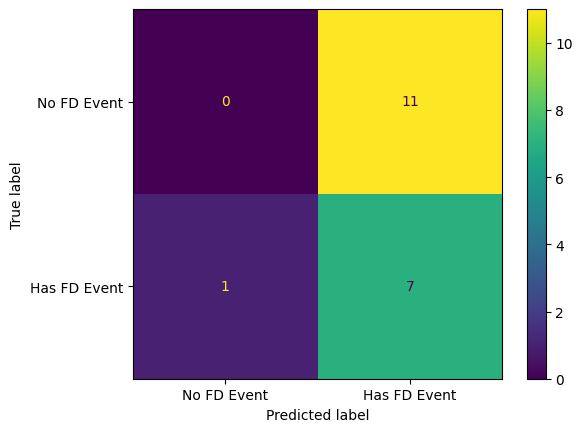

evaluation
FP    11
TP     7
FN     1
Name: count, dtype: int64

In [395]:
# Confusion matrix
eval_counts = df_check['evaluation'].value_counts()

# Convert result back to binary actual/predicted for matrix
actual_bin = df_check['evaluation'].isin(['TP', 'FN']).astype(int)
pred_bin = df_check['evaluation'].isin(['TP', 'FP']).astype(int)
cm = confusion_matrix(actual_bin, pred_bin)

# Display the confusion matrix!
disp = ConfusionMatrixDisplay(cm, display_labels=['No FD Event', 'Has FD Event'])
disp.plot()
plt.show()

# Show evaluation statistics too!
eval_counts.head()

In [396]:
# Evaluation matric compilation
TP = eval_counts.get('TP', 0)
FP = eval_counts.get('FP', 0)
FN = eval_counts.get('FN', 0)

# Compute metrics
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

print('===== METRICS =====')
print(f"Precision: {precision:.3f} \nRecall: {recall:.3f} \nF1 score: {f1:.3f}")

===== METRICS =====
Precision: 0.389 
Recall: 0.875 
F1 score: 0.538
